# Model Portability Analysis - Part 1
This work is &copy; 2023 by [William Caban](https://www.linkedin.com/in/williamcaban/) and licensed under [CC BY-SA 4.0](http://creativecommons.org/licenses/by-sa/4.0/?ref=chooser-v1)<img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/cc.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/by.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/sa.svg?ref=chooser-v1"></a>

---
## Goals of the project

Traditional AIOps approaches assume the environments over which they operate are homogeneous. Such systems expect the environment to have well-known applications where the combination and characteristics of the applications and the platform are known in advance. To achieve accuracy, traditional AIOps frameworks must be fine-tuned on customer-specific setups for each unique combination of platform and application workloads. The commercial AIOps ML models are a “black box” for the users, so there is no good information on how they operate. The requirement for fine-tuning each environment hints at some over-fitting technique.

This notebook studies an approach for portable AIOps ML models for the Kubernetes platform. The theory is that with more emphasis on the feature engineering process, we can achieve portable AIOps ML models. For an experiment to study this, the approach is to use metrics from Prometheus sources in Kubernetes to test this hypothesis.

Prometheus is a system for collecting metrics and generating alerts, which has become the de-facto standard tool for monitoring Kubernetes clusters. It maintains a multi-dimensional time series data model. Applying traditional machine learning methods to these time series metrics results in models that can be effective for the specific Kubernetes cluster as long as the attributes like memory per server, CPUs per server, density, and type of workloads, among others, are very close to identical.

This analysis investigates methods for feature engineering and scaling to create Machine Learning models that can be easily moved between Kubernetes clusters. The focus is on developing the ability to train a model on one cluster and then use it on other clusters, even if those clusters have different characteristics such as varying numbers of nodes, nodes with different properties like CPU and memory, and various application profiles in their Pods.

When successful, we should maintain a high accuracy of the ML model across two or more distinct clusters.

Some of the questions that I should be able to answer at the end of this project are:
- What is the most effective feature engineering technique to encode Prometheus metrics to create cluster-independent machine learning models?
- What ML algorithms work best as “portable” ML models across clusters?
- Feature scaling is not considered necessary with the Random Forest algorithm. How do the different feature engineering and feature scaling techniques used to improve the other algorithms impact the accuracy or performance of Random Forest for this use case?

### Approach

Capturing the datasets of the multi-nodes (mno) and (compact) clusters is done using the `metrics-collector` tool. The `data-analysis` tool consumes the resulting datasets for data wrangling, aggregation, and cleaning.

For the analysis, the Jupyter Notebook uses the libraries from the `data-analysis` tool, and a custom ML class `CustomML` implemented in the `custom_ml.py` is used to maintain a cleaner Notebook.

The feature definition is a YAML file with `promql` queries as follows:

```yaml
  
- name: etcd_member_down_total
  desc: total number of etcd members
  expr: |
    sum (
          sum without (instance) (up{job=~".*etcd.*"} == bool 0)
        or
          count without (To) (
            sum without (instance) (rate(etcd_network_peer_sent_failures_total{job=~".*etcd.*"}[120s])) > 0.01
          )
        )
  type: scalar

- name: etcd_failed_proposal
  desc: number of proposal failures of etcd cluster
  expr: sum by (pod) (rate(etcd_server_proposals_failed_total{job=~".*etcd.*"}[15m]))
  type: scalar_per_attribute

- name: etcd_fsync_duration
  desc: 99th percentile fsync duration/disk latency. A high value indicates disk issues.
  expr: sum by (instance) (histogram_quantile(0.99, rate(etcd_disk_wal_fsync_duration_seconds_bucket{job=~".*etcd.*"}[5m])))
  type: scalar_per_attribute


```
The full list of [feature-definition](https://github.com/smartctl/metrics-collector/blob/main/querysets/ocp-platform/features-definition.yaml) is on the `metrics-collector` repo.


The labels definitions follow a similar format, defining **boolean** attributes that will be used to impute the y_label of the observation. 

```yaml
- name: yy_kubelet_healthstate_critical_fatal
  expr: sum by (node)(max_over_time(mcd_kubelet_state[5m])) > bool 10
  desc: Returns 1 if 10 or more kubelet health failures occur
  type: boolean_per_node
  label: red_fatal

- name: yy_mem_used_gt_mem_reserved_95p
  desc: Return 1 if system exceeds reservations
  expr: |
    (
        sum by (node) (container_memory_rss{id="/system.slice"}) 
    ) - ((
        sum by (node) (kube_node_status_capacity{resource="memory"} - kube_node_status_allocatable{resource="memory"})
    ) * 0.95) > bool 0
  type: boolean_per_node
  label: red

- name: yy_mem_utilization_high
  desc: Return 1 if node mem utilization above 60% over the past 5mins
  expr: |
    (
          1 - ((sum(avg_over_time(kube_node_status_capacity{resource="memory"}[5m])) by (node) 
          - sum(avg_over_time(kube_pod_container_resource_requests{resource="memory"}[5m])) by (node))) 
          /  sum(avg_over_time(kube_node_status_capacity{resource="memory"}[5m])) by (node) > bool .60
    )
  type: boolean_per_node
  label: yellow
```

The full list of `yy_labels` or [labels-definitions](https://github.com/smartctl/metrics-collector/blob/main/querysets/ocp-platform/labels-definition.yaml) is on the `metrics-collector` repo.

The function imputing the y_label is `impute_y_label` method in the `DataTransformation` class. 

Once the y_label is imputed, all columns used for the labels definitions are dropped from the clean table. The final y_label has the values "green", "red", "yellow" encoded as 1, 2, 3 respectively.


### About the code

The code of for this project is divided in multiple folders by functionality.

```shell
.
├── data-analysis                   # contains the code for the analytics libraries created for this Jupyter Notebook
│   ├── data
│   │   ├── collection              # individual datasets of captures 
│   │   └── wrangle
│   ├── main.py
│   ├── mapping
│   │   ├── labels-definition.yaml  # boolean promql queries for defining yy_labels (later combined to create y_label)
│   │   └── mapping.yaml            # mapping of features to data types (dtypes)
│   ├── README.md
│   ├── requirements.txt
│   └── src
│       ├── config.py               # custom class to read yaml and handle logging
│       ├── custom_ml.py            # custom class with functions for the analysis in this Jupyter Notebook
│       ├── data_transformation.py  # library created to handle raw data transformation into clean dataset
│       └── data_wrangling.py       # library to combine datasets into an aggregated dataset and impute y_label 
│
├── metrics-collector               # contains the code created for collecting predefined metric
│   ├── config-template.yaml
│   ├── config.yaml-example
│   ├── CREDITS.md                  # File with the Credits of sources of reused code and reference information
│   ├── data                        # link to sample-datasets directory
│   ├── generate-config.sh
│   ├── main.py
│   ├── manifests
│   │   └── prometheus-api-token.yaml
│   ├── querysets                   # contains the features definition and labels definitions yaml files
│   │   └── ocp-platform
│   ├── README.md
│   ├── requirements.txt
│   └── src
│       ├── config.py
│       ├── metrics_processor.py    # collect and preprocess Prometheus metrics for data analysis
│       └── prometheus_api.py       # library to handle the interactions with Prometheus
│
├── promdata-offline                # utilities used for the load generation for the clusters
│   ├── CONFIG
│   ├── profiles
│   │   ├── build.sh
│   │   ├── Containerfile           # Container image for stress-ng for synthetic workload types simulations 
│   │   ├── kube-burner             # YAMLs generated by kube-burner execution on the various load profiles
│   │   ├── manifests               # Kubernetes manifests for running the stress-ng workload simulations
│   │   ├── README.md
│   │   └── scripts                 # scripts defining the stress-ng workload simulations
│   ├── README.md
│   └── utils                       # scripts to download raw Prometheus databases for offline processing
│       ├── CREDITS.md
│       ├── dump-prometheus-4hrs.sh  
│       ├── dump-prometheus-allhrs.sh
│       ├── load-testing.sh         # script for the cluster load testing during data capture
│       ├── metrics-4hrs
│       ├── metrics-all
│       └── README.md
│
└──sample-datasets                  # directory with raw captured data of the runs and the aggregated one
    ├── collection
    │   ├── aws-compact-fulltest.parquet
    │   ├── aws-compact-upgrade.parquet
    │   ├── aws-mno-fulltest.parquet
    │   ├── lab-compact-fulltest.parquet
    │   └── lab-mno-fulltest.parquet
    └── wrangle
        └── combined-all.parquet
```

### About the datasets
The datasets are generated by querying Prometheus metrics from OpenShift clusters with different configurations. The combined datasets represent different combinations of workload types and cluster conditions.

The core characteristics of the Kubernetes clusters used for this are

| Cluster Type | Number of Nodes | Num. Control-Plane (CP) Nodes | Num. Non-CP Nodes |
| ------------:|:---------------:|:-----------------------------:|:-----------------:|
| compact      | 3               |  3                            | 0                 |
| mno          | 6               |  3                            | 3                 | 

To generate the datasets, each cluster type was subject to multiple load generation tasks while using the metrics-collector tool for capturing the raw datasets. After the load generation tasks, the cluster was upgraded to capture additional conditions under which the cluster experiment a degraded state. The raw dataset was saved as a parquet formatted table.

The datasets used for this analysis are the following:

| Name                        | Cluster Type | Workload Type      |
|:----------------------------| ------------ | ------------------ |
| aws-compact-fulltest.parquet| compact      | [1][2][3][4][5][6] |
| aws-compact-upgrade.parquet | compact      | [1][2][3][6]       |
| aws-mno-fulltest.parquet    | mno          | [1][2][3][4][5][6] |
| lab-compact-fulltest.parquet| compact      | [1][2][3][4][5][6] |
| lab-mno-fulltest.parquet    | mno          | [1][2][3][4][5][6] |

- [1] stress-ng with high cpu & high memory profile
- [2] stress-ng with key-value store profile
- [3] stress-ng with password-encryption profile
- [4] kube-burner with node-density profile
- [5] kube-burner with cluster-density-v2
- [6] Online full cluster upgrade


## Section 1: Cleaning raw datasets

In [1]:
# %reload_ext autoreload
# %autoreload 2

import pandas as pd
import re, os, sys
import logging
import importlib
import pprint

# Need to chdir to parent due to notebook folder in repo
os.chdir(os.path.dirname(os.getcwd()))

# import custom classes
from src.config import Config
from src.data_wrangling import DataWrangle
from src.data_transformation import DataTransformation

os.environ['LOG_LEVEL']='INFO'

In [2]:
# Load the general mapping for features datatypes and attributes for y_labels definition
global_config = Config(
    config_file="mapping/mapping.yaml", 
    y_map_file="mapping/labels-definition.yaml"
)

# Using custom utility class for manipulation of the dataframes
data_wrangler=DataWrangle(mapping_set=global_config.config, 
                          y_map_set=global_config.y_map, 
                          logger=global_config.logger)

2023-09-04 09:42:47,113 [INFO] Successfully loaded the config YAML file.
2023-09-04 09:42:47,149 [INFO] Successfully loaded the y-map YAML file.



        #######################################################################################################
            For controlling verbosity of messages set LOG_LEVEL environment variable (e.g., INFO, DEBUG)
        #######################################################################################################
        


In [3]:
# Load dataset
fname_combined="data/wrangle/combined-all.parquet"
data_wrangler.load_dataset(fname_combined)

# Getting a local copy of the dataframe for
# testing without affecting the original one
df_raw=data_wrangler.df.copy()
df_raw[:3]

,run_id,node1_control_plane,node1_master,node1_worker,node2_control_plane,node2_master,node2_worker,node3_control_plane,node3_master,node3_worker,...,node4_node_pod_15_to_20mbps,node4_node_pod_10_to_15mbps,node5_nvme1n1,node6_node_pod_15_to_20mbps,node6_node_pod_20_to_30mbps,node4_node_pod_30_to_50mbps,node5_node_pod_10_to_15mbps,node5_exec,node4_exec,node6_exec
0,2023-08-12 14:48:27,True,True,True,True,True,True,True,True,True,...,False,False,0.0,False,False,False,False,False,False,False
1,2023-08-12 14:48:27,True,True,True,True,True,True,True,True,True,...,False,False,0.0,False,False,False,False,False,False,False
2,2023-08-12 14:48:27,True,True,True,True,True,True,True,True,True,...,False,False,0.0,False,False,False,False,False,False,False


In [4]:
# Shape of raw dataset
df_raw.shape

(3504, 586)

In [5]:
# Instantiate custom utility class for data transformation
# need to supply the attributes for y_labels definition 
dt_util = DataTransformation(
    y_label_yellow=data_wrangler.y_label_yellow,
    y_label_red=data_wrangler.y_label_red,
    y_label_red_fatal=data_wrangler.y_label_red_fatal
)

# derive y_labels for dataset using custom thresholds
# (thresholds yellow=2% red=1% red(fatal_red)=0%)
dt_util.impute_y_label(df_raw,label_weight=[0.02,0.01,0])
df_raw.shape

2023-09-04 09:42:47,904 [WARNING] [impute_y_label] Known issue. Requires optimization for performance.
2023-09-04 09:42:47,904 [WARNING] [impute_y_label] Known issue. Requires optimization for performance.


(3504, 590)

In [6]:
# study the y_label as coming from raw datasets
dt_util.y_by_group(df_raw)

----
By y_label:
 y_label
green     2079
red       1246
yellow     179
Name: y_label, dtype: int64

----
By source by y_label:
 source                        y_label
aws-compact-fulltest.parquet  green       230
                              red         987
aws-compact-upgrade.parquet   green       231
                              red          84
aws-mno-fulltest.parquet      green       225
                              red          12
                              yellow        1
lab-compact-fulltest.parquet  green      1021
                              red         143
                              yellow      178
lab-mno-fulltest.parquet      green       372
                              red          20
Name: source, dtype: int64


In [7]:
# Aggregate datasets by cluster type
# (only modifying the `source` column)
dt_util.normalize_sources(df_raw)

# show new aggregated results
dt_util.y_by_group(df_raw)

----
By y_label:
 y_label
green     2079
red       1246
yellow     179
Name: y_label, dtype: int64

----
By source by y_label:
 source   y_label
compact  green      1482
         red        1214
         yellow      178
mno      green       597
         red          32
         yellow        1
Name: source, dtype: int64


In [8]:
# drop unnecesary columns and remove duplicated rows
# get a clean dataset
df_clean=dt_util.get_clean_dataset(df_raw)

# shape of clean dataset
df_clean.shape

(2413, 468)

In [9]:
# show aggregate of cleaan dataset
dt_util.y_by_group(df_clean)

----
By y_label:
 y_label
green     2079
red        155
yellow     179
Name: y_label, dtype: int64

----
By source by y_label:
 source   y_label
compact  green      1482
         red         140
         yellow      178
mno      green       597
         red          15
         yellow        1
Name: source, dtype: int64


In [10]:
# Showing final list of columns in clean dataset
# to be used for the training of the ML models
df_clean.columns.to_list()

['node1_control_plane',
 'node1_worker',
 'node2_control_plane',
 'node2_worker',
 'node3_control_plane',
 'node3_worker',
 'node1_nodes_roles_per_node',
 'node2_nodes_roles_per_node',
 'node3_nodes_roles_per_node',
 'total_qty_nodes',
 'total_qty_control_plane',
 'total_qty_workers',
 'cluster_magic_split',
 'total_nodes_ready',
 'total_nodes_notready',
 'total_nodes_unknown',
 'total_nodes_diskpressure',
 'total_node_memorypressure',
 'total_node_pidpressure',
 'node1_node_status_ready',
 'node2_node_status_ready',
 'node3_node_status_ready',
 'node1_node_status_diskpressure',
 'node2_node_status_diskpressure',
 'node3_node_status_diskpressure',
 'node1_node_status_memorypressure',
 'node2_node_status_memorypressure',
 'node3_node_status_memorypressure',
 'node1_node_status_pidpressure',
 'node2_node_status_pidpressure',
 'node3_node_status_pidpressure',
 'node1_node_load1',
 'node2_node_load1',
 'node3_node_load1',
 'node1_node_load5',
 'node2_node_load5',
 'node3_node_load5',
 'nod

## Section 2: Comparing Machine Learning Models

The dataset contains a label `y_label`, which can be `green`, `yellow`, `red`. The comparative uses various ML algorithms and algorithms like "logistic regression" will only be able to have a binary classification. In such case, it will only determine if the target variable is "red" or not. 

The analysis in this section uses the following ML algorithms:
- Logistic Regression (note: only to determine if "red" is true or false)
- K-Means
- Random Forest

In [11]:
# loading common ML libraries and setting defaults
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
#from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt 
import numpy as np


# import custom ML utility class
from src.custom_ml import CustomML

# global defaults
RANDOM_STATE=42
SPLIT_SIZE=0.25

In [12]:
# Get our full dataset X_data
ml_util = CustomML(X_data=df_clean.copy(),
                   random_state=RANDOM_STATE,
                   split_size=SPLIT_SIZE)

Compact cluster (1800, 467)
Multinode (mno) (613, 467)
Loaded dataset with shape (2413, 467)


### 2.1 Logistic Regression

The Logistic Regression requires the dependent variable to be binary. We transform y_label into a binary True/False column to achieve this. In this case, 1="red", 0="green". For this analysis, all "yellow" will be encoded as "red".

In [13]:
# get dataset with reencoded y_label as binary label
X_logreg, y_logreg=ml_util.get_xy_logreg("full")

y_label
0    2079
1     334
Name: count, dtype: int64


In [14]:
# split into training and testing datasets
X_train_logreg, X_test_logreg, y_train_logreg, y_test_logreg = train_test_split(
    X_logreg, y_logreg, 
    test_size=SPLIT_SIZE, random_state=RANDOM_STATE)

In [15]:
# confirm split distribution among subsets
print(f"{y_train_logreg.value_counts()}\n\n{y_test_logreg.value_counts()}")

y_label
False    1573
True      236
Name: count, dtype: Int64

y_label
False    506
True      98
Name: count, dtype: Int64


As we see from the Scikit-Learn [solvers documentation](https://scikit-learn.org/stable/modules/linear_model.html#solvers) the ideal solver for when `n_samples >> n_features` is the `newton-choleskey` solver. Here is an extract from the documentation.

```
The “newton-cholesky” solver is an exact Newton solver that calculates the hessian matrix and solves the resulting linear system. It is a very good choice for n_samples >> n_features, but has a few shortcomings: Only $l_2$ regularization is supported. Furthermore, because the hessian matrix is explicitly computed, the memory usage has a quadratic dependency on n_features as well as on n_classes. As a consequence, only the one-vs-rest scheme is implemented for the multiclass case.
```

I've tried other solvers but they have problems converging or are too slow.

```bash
# Using solver='newton-cheleskey'
1.82 s ± 526 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# Using solver='saga'
26.3 s ± 607 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

For this reason, I've selected the use of the `solver='newton-choleskey'` with the `penalty=`$l_2$

In [16]:
# Using pipelines and ColumnTransformers to apply different transformations to columns with differnt dtypes (uint32, float64)
# Scalers options available in custom function StandardScaler, MaxAbsScaler, MinMaxScaler, PowerTransformer
# https://scikit-learn.org/stable/modules/preprocessing.html

# get ColumnTransformer with corresponding pipelines
ct  = ml_util.feature_scaling_per_type(X_train_logreg,'maxabs','power')

# LogisticRegression instance with settings
logreg = LogisticRegression(random_state=RANDOM_STATE, penalty='l2',
                                      solver='newton-cholesky',
                                      class_weight='balanced',
                                      max_iter=3000)
# Main pipeline for fitting.
pipeline = Pipeline([
                   ('column_transformer', ct),
                   ('logistic_regression', logreg)
])

In [17]:
pipeline.fit(X_train_logreg, y_train_logreg)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('scaler_uint32',
                                                  Pipeline(steps=[('maxabs',
                                                                   MaxAbsScaler())]),
                                                  ['node1_nodes_roles_per_node',
                                                   'node2_nodes_roles_per_node',
                                                   'node3_nodes_roles_per_node',
                                                   'total_qty_nodes',
                                                   'total_qty_control_plane',
                                                   'total_qty_workers',
                                                   'total_nodes_ready',
                                                   'total_nodes_notready',
                                                   'total_nodes_unknown',
                                                   't...
                                                   'node1_node_pod_container_resource_requests_memory',
                                                   'node1_node_pod_container_resource_limit_cpu',
                                                   'node2_node_pod_container_resource_limit_cpu',
                                                   'node3_node_pod_container_resource_limit_cpu',
                                                   'node1_node_capacity_cpu',
                                                   'node2_node_capacity_cpu',
                                                   'node3_node_capacity_cpu', ...])])),
                ('logistic_regression',
                 LogisticRegression(class_weight='balanced', max_iter=3000,
                                    random_state=42,
                                    solver='newton-cholesky'))])

In [18]:
pipeline.score(X_test_logreg, y_test_logreg)

0.9850993377483444

In [19]:
# Determine model scores
y_pred_logreg=pipeline.predict(X_test_logreg)
_ = ml_util.get_model_scores(y_test_logreg, y_pred_logreg, False)

           accuracy_score	0.9850993377483444
  balanced_accuracy_score	0.9787650237960797
                 f1_score	0.9729270734246057
          precision_score	0.9673149223471055
             recall_score	0.9787650237960797
       mean_squared_error	0.014900662251655629


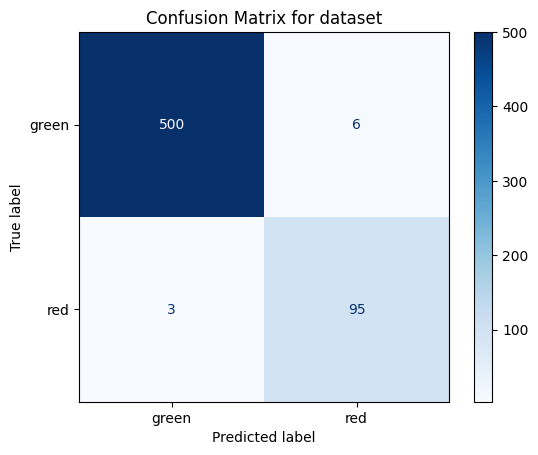

In [20]:
ml_util.show_confusion_matrix(y_test_logreg, y_pred_logreg, logreg=True)

In [21]:
# define transformer pair for uint32 columns and float64 columns
# to determine how is the score affected
scaler_pairs=[
    ('standard','standard'),
    ('power','minmax'),
    ('maxabs','maxabs'),
    ('power','power'),
    ('maxabs','standard')
]

_= ml_util.pipeline_transformer_logreg(X_train_logreg, y_train_logreg,
                                       X_test_logreg, y_test_logreg,
                                       scaler_pairs=scaler_pairs)

        standard,standard	0.9917218543046358
             power,minmax	0.9917218543046358
            maxabs,maxabs	0.9884105960264901
              power,power	0.9884105960264901
          maxabs,standard	0.9917218543046358


**Discussion**

When considering the whole dataset which combines the two types of clusters, transforming the features with the various scalers has about 1% improvements which is not significant among the scalers. Now lets compare how it behaves across clusters types (compact vs mno)

In [22]:
# Get a structure with per cluster datasets with
# keys ['X_full', 'X', 'y', 'X_train', 'y_train', 'X_test', 'y_test']
X_clusters = ml_util.get_xy_by_cluster_type()

In [23]:
# create y_logreg with values 0 or 1
X_clusters['compact']['y_train_logreg']=X_clusters['compact']['y_train'].astype('bool').replace({False:0, True:1})
X_clusters['compact']['y_test_logreg']=X_clusters['compact']['y_test'].astype('bool').replace({False:0, True:1})
print(f"Cluster Type: compact\n{X_clusters['compact']['y_train_logreg'].value_counts()}")

X_clusters['mno']['y_train_logreg']=X_clusters['mno']['y_train'].astype('bool').replace({False:0, True:1})
X_clusters['mno']['y_test_logreg']=X_clusters['mno']['y_test'].astype('bool').replace({False:0, True:1})
print(f"Cluster Type: mno\n{X_clusters['mno']['y_train_logreg'].value_counts()}")

Cluster Type: compact
y_label
0    1127
1     223
Name: count, dtype: int64
Cluster Type: mno
y_label
0    447
1     12
Name: count, dtype: int64


Using the `compact` cluster to predict the multi-node `mno` cluster lets determine how the various scalers affect the score.

In [24]:
# Testing how well we can map from COMPACT to MNO clusters

# define transformer pair for uint32 columns and float64 columns
scaler_pairs=[
    ('standard','standard'),
    ('power','minmax'),
    ('maxabs','maxabs'),
    ('power','power'),
    ('maxabs','standard')
]

_=ml_util.pipeline_transformer_logreg(X_clusters['compact']['X_train'], X_clusters['compact']['y_train_logreg'],
                                      X_clusters['mno']['X_train'], X_clusters['mno']['y_train_logreg'],
                                      scaler_pairs=scaler_pairs)

        standard,standard	0.6535947712418301
             power,minmax	0.9891067538126361
            maxabs,maxabs	0.8627450980392157
              power,power	0.9891067538126361
          maxabs,standard	0.6252723311546841


**Discussion**

This test shows that using the `PowerTransformer` on `uint32` columns and the `MinMaxScaler` or `PowerTransformer` for the `float64` columns leads to the best score. Anything using the `StandardScaler` is particularly detrimental to these predictions.

Next, we use the multi-node `mno` model to predict the state of the `compact` cluster and how the various scalers affect the score.

In [25]:
# Testing how well we can map from MNO to COMPAT clusters

# define transformer pair for uint32 columns and float64 columns
scaler_pairs=[
    ('standard','standard'),
    ('power','minmax'),
    ('maxabs','maxabs'),
    ('power','power'),
    ('maxabs','standard')
]

_=ml_util.pipeline_transformer_logreg(X_clusters['mno']['X_train'], X_clusters['mno']['y_train_logreg'],
                                      X_clusters['compact']['X_train'], X_clusters['compact']['y_train_logreg'],
                                      scaler_pairs=scaler_pairs)

        standard,standard	0.825925925925926
             power,minmax	0.837037037037037
            maxabs,maxabs	0.8266666666666667
              power,power	0.8362962962962963
          maxabs,standard	0.8296296296296296


**Discussion**

It is interesting to see a similar pattern as from the combined dataset where the selection of scaler has a score with $~1%$ difference, which makes the specific scaler non-significant.

Now, considering the previous results of using the `compact` model to predict `mno`, using the `PowerTransformer` for scaling both types of columns (`uint32` and `float64`), or the `MinMaxScaler` for the `float64` columns are the best options to consider

With this, let's build the final `LogisticRegression` model and look at all the scores and confusion matrix.

In [26]:
# get ColumnTransformer with corresponding pipelines
ct_mno = ml_util.feature_scaling_per_type(X_clusters['mno']['X_train'],'power','power')
ct_compact = ml_util.feature_scaling_per_type(X_clusters['compact']['X_train'],'power','power')

# LogisticRegression instance with settings
log_model = LogisticRegression(random_state=RANDOM_STATE, penalty='l2', solver='newton-cholesky', 
                               class_weight='balanced', max_iter=3000)

# Main pipeline for fitting.
pipe_log_mno = Pipeline([
                   ('column_transformer', ct_mno),
                   ('logistic_regression', log_model)
])

pipe_log_compact = Pipeline([
                   ('column_transformer', ct_compact),
                   ('logistic_regression', log_model)
])

In [27]:
# Train mno cluster model
pipe_log_mno.fit(X_clusters['mno']['X_train'], X_clusters['mno']['y_train_logreg'])

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('scaler_uint32',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer())]),
                                                  ['node1_nodes_roles_per_node',
                                                   'node2_nodes_roles_per_node',
                                                   'node3_nodes_roles_per_node',
                                                   'total_qty_nodes',
                                                   'total_qty_control_plane',
                                                   'total_qty_workers',
                                                   'total_nodes_ready',
                                                   'total_nodes_notready',
                                                   'total_nodes_unknown'...
                                                   'node1_node_pod_container_resource_requests_memory',
                                                   'node1_node_pod_container_resource_limit_cpu',
                                                   'node2_node_pod_container_resource_limit_cpu',
                                                   'node3_node_pod_container_resource_limit_cpu',
                                                   'node1_node_capacity_cpu',
                                                   'node2_node_capacity_cpu',
                                                   'node3_node_capacity_cpu', ...])])),
                ('logistic_regression',
                 LogisticRegression(class_weight='balanced', max_iter=3000,
                                    random_state=42,
                                    solver='newton-cholesky'))])

In [28]:
# Train compact cluster model
pipe_log_compact.fit(X_clusters['compact']['X_train'], X_clusters['compact']['y_train_logreg'])

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('scaler_uint32',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer())]),
                                                  ['node1_nodes_roles_per_node',
                                                   'node2_nodes_roles_per_node',
                                                   'node3_nodes_roles_per_node',
                                                   'total_qty_nodes',
                                                   'total_qty_control_plane',
                                                   'total_qty_workers',
                                                   'total_nodes_ready',
                                                   'total_nodes_notready',
                                                   'total_nodes_unknown'...
                                                   'node1_node_pod_container_resource_requests_memory',
                                                   'node1_node_pod_container_resource_limit_cpu',
                                                   'node2_node_pod_container_resource_limit_cpu',
                                                   'node3_node_pod_container_resource_limit_cpu',
                                                   'node1_node_capacity_cpu',
                                                   'node2_node_capacity_cpu',
                                                   'node3_node_capacity_cpu', ...])])),
                ('logistic_regression',
                 LogisticRegression(class_weight='balanced', max_iter=3000,
                                    random_state=42,
                                    solver='newton-cholesky'))])

In [29]:
# Determine model scores of MNO predicting COMPACT
y_pred_logreg_mno=pipe_log_mno.predict(X_clusters['compact']['X_test'])
_ = ml_util.get_model_scores(X_clusters['compact']['y_test_logreg'], y_pred_logreg_mno)

           accuracy_score	0.7933333333333333
  balanced_accuracy_score	0.5105263157894737
                 f1_score	0.46271071112195244
          precision_score	0.8962053571428572
             recall_score	0.5105263157894737
       mean_squared_error	0.20666666666666667


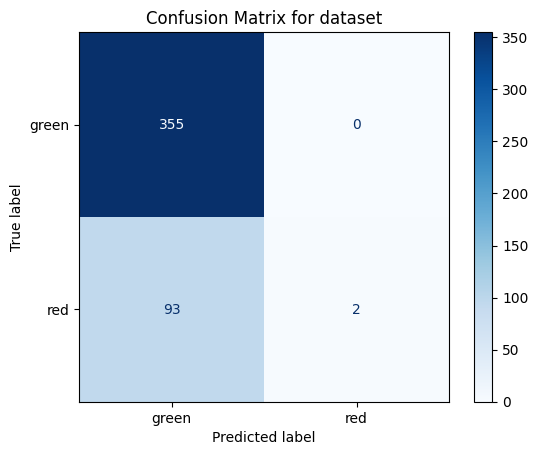

In [30]:
ml_util.show_confusion_matrix(X_clusters['compact']['y_test_logreg'], y_pred_logreg_mno, logreg=True)

In [31]:
# Determine model scores of COMPACT predicting MNO
y_pred_logreg_compact=pipe_log_compact.predict(X_clusters['mno']['X_test'])
_ = ml_util.get_model_scores(X_clusters['mno']['y_test_logreg'], y_pred_logreg_compact)

           accuracy_score	0.987012987012987
  balanced_accuracy_score	0.75
                 f1_score	0.8300220750551877
          precision_score	0.993421052631579
             recall_score	0.75
       mean_squared_error	0.012987012987012988


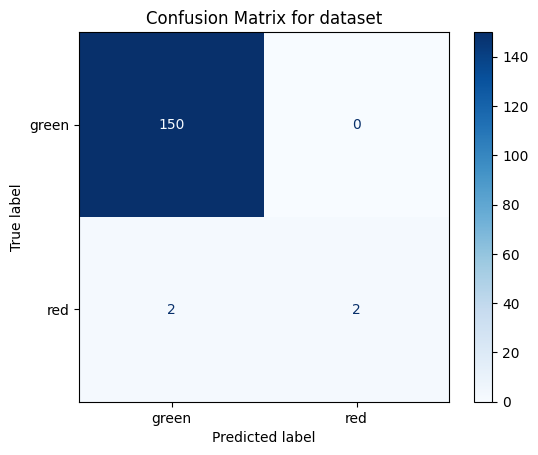

In [32]:
ml_util.show_confusion_matrix(X_clusters['mno']['y_test_logreg'], y_pred_logreg_compact, logreg=True)

**Discusion**

From the results above, it would appear the `compact` cluster is better at predicting `mno` than the `mno` is at predicting the `compact` clusters. We would need a much larger dataset to determine if this holds.

### 2.2 K-Means

The dataset uses a target variable y_label with $0=green$, $1=red$ and $2=yellow$

The dataset is evaluated and transformed using the best scalers identified in the previous section and without any transformations to identify if there are relevant improvements between the two approaches.

In [33]:
# Obtain a copy of the X,y split combined dataset
X_train=ml_util.X_train
y_train=ml_util.y_train

X_test=ml_util.X_test
y_test=ml_util.y_test

In [34]:
# Create two KMeans model
kmeans_model1 = KMeans(n_clusters=3,
                      max_iter=1000,
                      verbose=False,
                      random_state=RANDOM_STATE,
                      tol=0.0001, # default 0.0001
                      algorithm='lloyd' # 'lloyd' or 'elkan'
                     )

kmeans_model2 = KMeans(n_clusters=3,
                      max_iter=1000,
                      verbose=False,
                      random_state=RANDOM_STATE,
                      tol=0.0001, # default 0.0001
                      algorithm='lloyd' # 'lloyd' or 'elkan'
                     )

In [35]:
# Scale features using same scalers as previous section
ct=ml_util.feature_scaling_per_type(X_train, 'power', 'power')

# Pipeline for fitting the model:
# with column transformer
pipe_kmeans_scaled = Pipeline([
    ('column_transformer', ct),
    ('kmeans_model', kmeans_model1)
])
# without scaling data
pipe_kmeans = Pipeline([
    ('kmeans_model', kmeans_model2)
])

In [36]:
# Training scaled model
pipe_kmeans_scaled.fit(X_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('scaler_uint32',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer())]),
                                                  ['node1_nodes_roles_per_node',
                                                   'node2_nodes_roles_per_node',
                                                   'node3_nodes_roles_per_node',
                                                   'total_qty_nodes',
                                                   'total_qty_control_plane',
                                                   'total_qty_workers',
                                                   'total_nodes_ready',
                                                   'total_nodes_notready',
                                                   'total_nodes_unknown'...
                                                   'node1_node_pod_container_resource_requests_memory',
                                                   'node1_node_pod_container_resource_limit_cpu',
                                                   'node2_node_pod_container_resource_limit_cpu',
                                                   'node3_node_pod_container_resource_limit_cpu',
                                                   'node1_node_capacity_cpu',
                                                   'node2_node_capacity_cpu',
                                                   'node3_node_capacity_cpu', ...])])),
                ('kmeans_model',
                 KMeans(max_iter=1000, n_clusters=3, random_state=42,
                        verbose=False))])

In [37]:
# Training unscaled model
pipe_kmeans.fit(X_train)

Pipeline(steps=[('kmeans_model',
                 KMeans(max_iter=1000, n_clusters=3, random_state=42,
                        verbose=False))])

In [38]:
# A good model should have a low intertia
print(f"Scaled dataset:\nNum. iterations: {pipe_kmeans_scaled.named_steps.kmeans_model.n_iter_}\n"
      +f"\tInertia: {pipe_kmeans_scaled.named_steps.kmeans_model.inertia_}")

print(f"Unscaled dataset:\nNum. iterations: {pipe_kmeans.named_steps.kmeans_model.n_iter_}\n"
      +f"\tInertia: {pipe_kmeans.named_steps.kmeans_model.inertia_}")

Scaled dataset:
Num. iterations: 3
	Inertia: 361868.69698219385
Unscaled dataset:
Num. iterations: 2
	Inertia: 3.867108127896277e+23


**Discussion**

A good KMeans model should have low "inertia". From the results above scaling the features has a negative impact on the "inertia" attribute. For the remainder of this section, the evaluation will use the unscaled model.

In [39]:
# Confirm distribution among groups
np.unique(pipe_kmeans.named_steps.kmeans_model.labels_, return_counts=True)

(array([0, 1, 2], dtype=int32), array([ 450, 1345,   14]))

In [40]:
# Compare quantities with actual y
y_train.value_counts()

y_label
0    1573
2     129
1     107
Name: count, dtype: int64

In [41]:
# Determine model scores
y_pred_kmeans=pipe_kmeans.predict(X_train)
_ = ml_util.get_model_scores(y_train, y_pred_kmeans)

           accuracy_score	0.29574350469872857
  balanced_accuracy_score	0.37757682702457557
                 f1_score	0.18809880134195955
          precision_score	0.3514415530772408
             recall_score	0.37757682702457557
       mean_squared_error	0.710889994472084


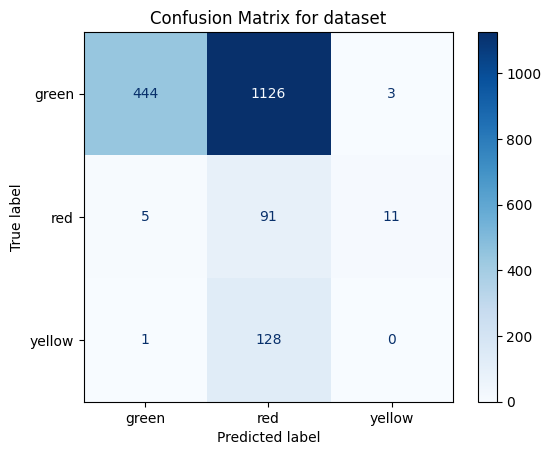

In [42]:
ml_util.show_confusion_matrix(y_train, y_pred_kmeans)

**Discussion**

As seen from the model scores, when using a combined dataset **the model canNOT predict** the target variable. This model is not usable.

In the next steps, we will do a similar analysis but for a specific cluster type.

In [43]:
# Using the previously acquired structure with per cluster datasets with
# keys ['X_full', 'X', 'y', 'X_train', 'y_train', 'X_test', 'y_test']
for k in X_clusters.keys():
    print(X_clusters[k].keys())

dict_keys(['X_full', 'X', 'y', 'X_train', 'y_train', 'X_test', 'y_test', 'y_train_logreg', 'y_test_logreg'])
dict_keys(['X_full', 'X', 'y', 'X_train', 'y_train', 'X_test', 'y_test', 'y_train_logreg', 'y_test_logreg'])


In [44]:
# Create KMeans model per cluster type
kmeans_model_compact = KMeans(n_clusters=3, 
                              max_iter=1000, 
                              verbose=False, 
                              random_state=RANDOM_STATE,
                              tol=0.0001, # default 0.0001
                              algorithm='lloyd' # 'lloyd' or 'elkan'
                             )

kmeans_model_mno = KMeans(n_clusters=3, 
                          max_iter=1000, 
                          verbose=False, 
                          random_state=RANDOM_STATE,
                          tol=0.0001, # default 0.0001
                          algorithm='lloyd' # 'lloyd' or 'elkan'
                         )


In [45]:
# Pipeline for fitting the model:
pipe_kmeans_compact = Pipeline([
    ('kmeans_model', kmeans_model_compact)
])
# without scaling data
pipe_kmeans_mno = Pipeline([
    ('kmeans_model', kmeans_model_mno)
])

In [46]:
pipe_kmeans_compact.fit(X_clusters['compact']['X_train'])

Pipeline(steps=[('kmeans_model',
                 KMeans(max_iter=1000, n_clusters=3, random_state=42,
                        verbose=False))])

In [47]:
pipe_kmeans_mno.fit(X_clusters['mno']['X_train'])

Pipeline(steps=[('kmeans_model',
                 KMeans(max_iter=1000, n_clusters=3, random_state=42,
                        verbose=False))])

In [48]:
# Quantity of labels per class
np.unique(pipe_kmeans_compact.named_steps.kmeans_model.labels_, return_counts=True)

(array([0, 1, 2], dtype=int32), array([984, 360,   6]))

In [49]:
# Quantity of actual labels
X_clusters['compact']['y_train'].value_counts()

y_label
0    1127
2     123
1     100
Name: count, dtype: int64

In [50]:
# Determine model scores
y_pred_kmeans_compact=pipe_kmeans.predict(X_clusters['compact']['X_test'])
_ = ml_util.get_model_scores(X_clusters['compact']['y_test'].astype('uint32'), y_pred_kmeans_compact)

           accuracy_score	0.08
  balanced_accuracy_score	0.3
                 f1_score	0.049484536082474224
          precision_score	0.026966292134831458
             recall_score	0.3
       mean_squared_error	0.9266666666666666


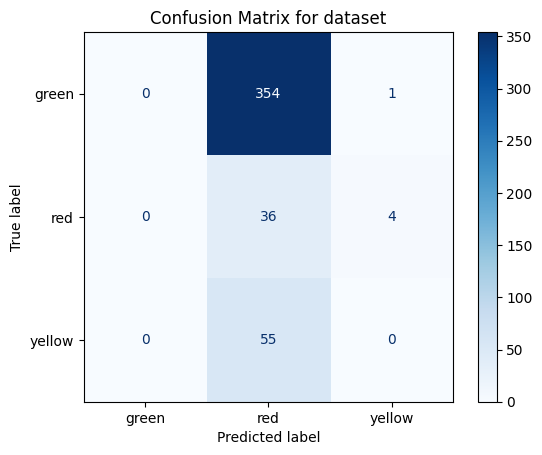

In [51]:
ml_util.show_confusion_matrix(X_clusters['compact']['y_test'].astype('uint32'), y_pred_kmeans_compact)

           accuracy_score	0.974025974025974
  balanced_accuracy_score	0.5
                 f1_score	0.3311258278145695
          precision_score	0.3289473684210526
             recall_score	0.3333333333333333
       mean_squared_error	0.025974025974025976


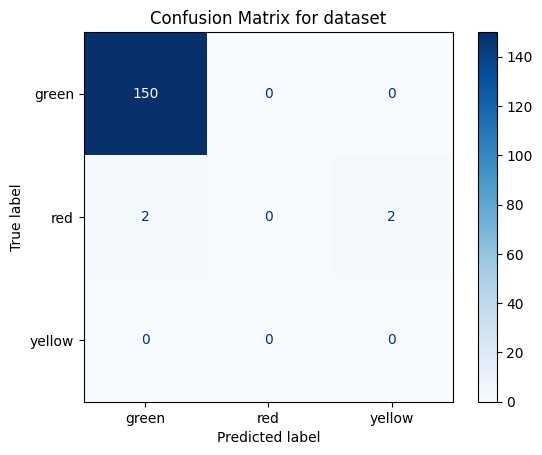

In [52]:
# Determine model scores
y_pred_kmeans_mno=pipe_kmeans.predict(X_clusters['mno']['X_test'])
_ = ml_util.get_model_scores(X_clusters['mno']['y_test'].astype('uint32'), y_pred_kmeans_mno)

ml_util.show_confusion_matrix(X_clusters['mno']['y_test'].astype('uint32'), y_pred_kmeans_mno)

**Discussion**

As we can see with this model scores and confusion matrix results above, the `KMeans` algorithm is **NOT** suitable for this purpose when we have a specific classification. It might be the case that the algorithm is detecting a different type of grouping due to how data of the nodes is present or not based on the type of cluster or if the control plane is schedulable. We would need a dataset of features not present in the current samples to test those other hypotheses. 

### 2.3 Radom Forest Classifier

The dataset uses a target variable y_label with $0=green$, $1=red$ and $2=yellow$

The dataset is evaluated and transformed using the best scalers identified in section 2.1 and also without any transformations to identify if there are relevant improvements between the two approaches.

In [53]:
# First will do evaluation with the X,y combined dataset
X_train.shape , X_test.shape

((1809, 465), (604, 465))

In [54]:
# Create two RandomForest models
rf_model1 = RandomForestClassifier(n_estimators = 100, 
                                   criterion = 'gini', # 'entropy', 
                                   max_features = 'log2',
                                   n_jobs = -1, # num of parallel jobs, when -1 use all processors
                                   random_state = RANDOM_STATE)

rf_model2 = RandomForestClassifier(n_estimators = 100, 
                                   criterion = 'gini', # 'entropy', 
                                   max_features = 'log2',
                                   n_jobs = -1, # num of parallel jobs, when -1 use all processors
                                   random_state = RANDOM_STATE)

In [55]:
# Scale features using same scalers as found in section 2.1
ct=ml_util.feature_scaling_per_type(X_train, 'power', 'power')

# Pipeline for fitting the model:
# with column transformer
rf_scaled = Pipeline([
    ('column_transformer', ct),
    ('rf_model', rf_model1)
])
# without scaling data
rf = Pipeline([
    ('rf_model', rf_model2)
])

In [56]:
rf_scaled.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('scaler_uint32',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer())]),
                                                  ['node1_nodes_roles_per_node',
                                                   'node2_nodes_roles_per_node',
                                                   'node3_nodes_roles_per_node',
                                                   'total_qty_nodes',
                                                   'total_qty_control_plane',
                                                   'total_qty_workers',
                                                   'total_nodes_ready',
                                                   'total_nodes_notready',
                                                   'total_nodes_unknown'...
                                                   'node1_node_pod_container_resource_requests_memory',
                                                   'node1_node_pod_container_resource_limit_cpu',
                                                   'node2_node_pod_container_resource_limit_cpu',
                                                   'node3_node_pod_container_resource_limit_cpu',
                                                   'node1_node_capacity_cpu',
                                                   'node2_node_capacity_cpu',
                                                   'node3_node_capacity_cpu', ...])])),
                ('rf_model',
                 RandomForestClassifier(max_features='log2', n_jobs=-1,
                                        random_state=42))])

In [57]:
rf.fit(X_train, y_train)

Pipeline(steps=[('rf_model',
                 RandomForestClassifier(max_features='log2', n_jobs=-1,
                                        random_state=42))])

           accuracy_score	0.9817880794701986
  balanced_accuracy_score	0.9433014931927975
                 f1_score	0.9433424578155756
          precision_score	0.9435111302391054
             recall_score	0.9433014931927975
       mean_squared_error	0.028145695364238412


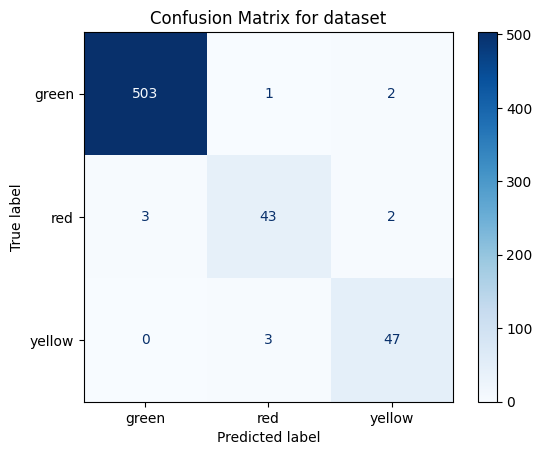

In [58]:
# Determine model scores when scaled
y_pred_rf_scaled=rf_scaled.predict(X_test)
_ = ml_util.get_model_scores(y_test, y_pred_rf_scaled)

ml_util.show_confusion_matrix(y_test, y_pred_rf_scaled)

           accuracy_score	0.9817880794701986
  balanced_accuracy_score	0.9430237154150198
                 f1_score	0.9431119292160428
          precision_score	0.9443549523122945
             recall_score	0.9430237154150198
       mean_squared_error	0.028145695364238412


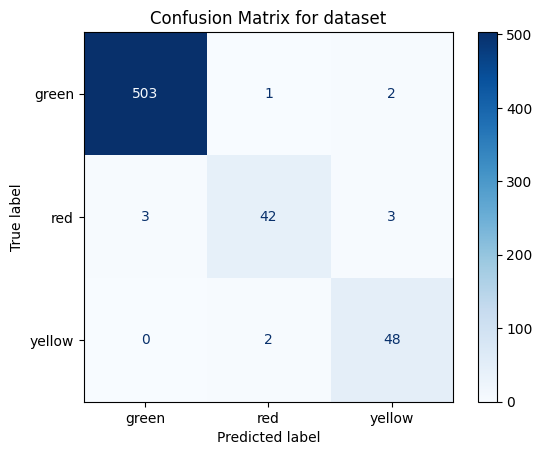

In [59]:
# Determine model scores without scaling
y_pred_rf=rf.predict(X_test)
_ = ml_util.get_model_scores(y_test, y_pred_rf)

ml_util.show_confusion_matrix(y_test, y_pred_rf)

**Discussion**

From the results above, we can see excellent scores for the scaled and not-scaled models. The difference in scores between the two models is not statistically significant. The next section will use the model without scaling the features to validate that the results are maintained. If that is the case, we will determine if we can use a model trained in one cluster type to predict the other.

In [60]:
# Using the previously acquired structure with per cluster datasets with
# keys ['X_full', 'X', 'y', 'X_train', 'y_train', 'X_test', 'y_test']
for k in X_clusters.keys():
    print(X_clusters[k].keys())

dict_keys(['X_full', 'X', 'y', 'X_train', 'y_train', 'X_test', 'y_test', 'y_train_logreg', 'y_test_logreg'])
dict_keys(['X_full', 'X', 'y', 'X_train', 'y_train', 'X_test', 'y_test', 'y_train_logreg', 'y_test_logreg'])


In [61]:
# Create a RandomForest model per cluster type COMPACT and MNO
rf_model_compact = RandomForestClassifier(n_estimators = 100, 
                                   criterion = 'gini', # 'entropy', 
                                   max_features = 'log2',
                                   #max_depth = 10,
                                   n_jobs = -1, # num of parallel jobs, when -1 use all processors
                                   random_state = RANDOM_STATE)

rf_model_mno = RandomForestClassifier(n_estimators = 100, 
                                   criterion = 'gini', # 'entropy', 
                                   max_features = 'log2',
                                   #max_depth = 10,
                                   n_jobs = -1, # num of parallel jobs, when -1 use all processors
                                   random_state = RANDOM_STATE)

In [62]:
# Pipeline for fitting the model for each cluster type

rf_compact = Pipeline([
    ('rf_model', rf_model_compact)
])

rf_mno = Pipeline([
    ('rf_model', rf_model_mno)
])

In [63]:
rf_compact.fit(X_clusters['compact']['X_train'], X_clusters['compact']['y_train'].astype('uint32'))

Pipeline(steps=[('rf_model',
                 RandomForestClassifier(max_features='log2', n_jobs=-1,
                                        random_state=42))])

In [64]:
rf_mno.fit(X_clusters['mno']['X_train'], X_clusters['mno']['y_train'].astype('uint32'))

Pipeline(steps=[('rf_model',
                 RandomForestClassifier(max_features='log2', n_jobs=-1,
                                        random_state=42))])

           accuracy_score	0.9733333333333334
  balanced_accuracy_score	0.9261523687580026
                 f1_score	0.9301166679414665
          precision_score	0.9346641721103701
             recall_score	0.9261523687580026
       mean_squared_error	0.03333333333333333


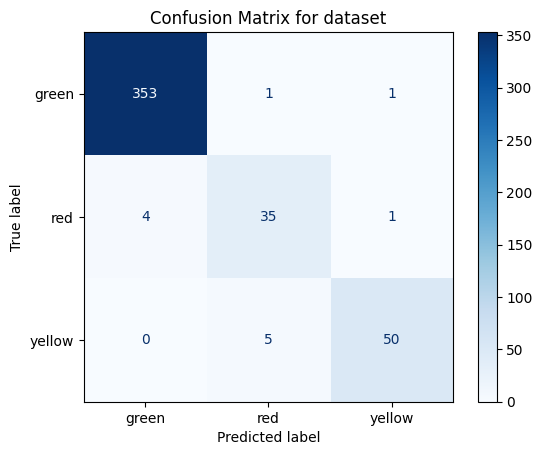

In [65]:
# Determine model scores for compact
y_pred_rf_compact=rf_compact.predict(X_clusters['compact']['X_test'])
_ = ml_util.get_model_scores(X_clusters['compact']['y_test'].astype('uint32'), y_pred_rf_compact)

ml_util.show_confusion_matrix(X_clusters['compact']['y_test'].astype('uint32'), y_pred_rf_compact)

In [66]:
# Determine model scores for mno
y_pred_rf_mno=rf_mno.predict(X_clusters['mno']['X_test'])
_ = ml_util.get_model_scores(X_clusters['mno']['y_test'].astype('uint32'), y_pred_rf_mno)

#ml_util.show_confusion_matrix(X_clusters['mno']['y_test'].astype('uint32'), y_pred_rf_mno)

           accuracy_score	0.987012987012987
  balanced_accuracy_score	0.75
                 f1_score	0.8300220750551877
          precision_score	0.993421052631579
             recall_score	0.75
       mean_squared_error	0.012987012987012988


**Discussion**

With this results we can see very good results for the both cluster types: `compact` and `mno`. Let's see how well a cluster type can predict the other and vice versa.

In [67]:
# Determine model scores for COMPACT predicting MNO
y_pred_rf_c2m=rf_compact.predict(X_clusters['mno']['X_test'])
_ = ml_util.get_model_scores(X_clusters['mno']['y_test'].astype('uint32'), y_pred_rf_c2m)

#ml_util.show_confusion_matrix(X_clusters['mno']['y_test'].astype('uint32'), y_pred_rf_c2m)

           accuracy_score	0.9545454545454546
  balanced_accuracy_score	0.49
                 f1_score	0.48837209302325585
          precision_score	0.4867549668874172
             recall_score	0.49
       mean_squared_error	0.045454545454545456


           accuracy_score	0.8066666666666666
  balanced_accuracy_score	0.43697183098591547
                 f1_score	0.4459098278052842
          precision_score	0.5108024691358025
             recall_score	0.43697183098591547
       mean_squared_error	0.56


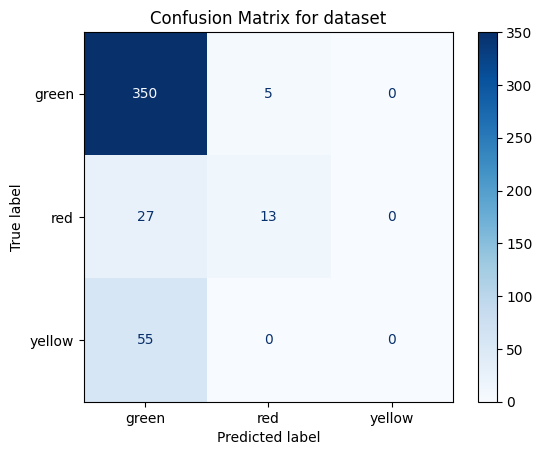

In [68]:
# Determine model scores for MNO predicting COMPACTS
y_pred_rf_m2c=rf_mno.predict(X_clusters['compact']['X_test'])
_ = ml_util.get_model_scores(X_clusters['compact']['y_test'].astype('uint32'), y_pred_rf_m2c)

ml_util.show_confusion_matrix(X_clusters['compact']['y_test'].astype('uint32'), y_pred_rf_m2c)

**Discussion**

What we can see from this last comparison of `compact` predicting `mno` clusters, and `mno` predicting `compact` clusters is that models trained for `compact` clusters are excellent predictors with ~2% difference from when trained with the full dataset combining both types of clusters. Unfortunately, the model trained with the `mno` cluster, while having a good accuracy, the F1-scores and the mean squared error indicate the model does not perform well.

## Section 3: Analysis

When started working on testing the hypothesis that it is possible to create machine learning (ML) models for cluster characteristics and attributes that the cluster(s) being used to train the model and still maintain a high level of accuracy on those predictions.

The type of features selected and the encoding of the data in three types the preparation of the datasets might have played a significant role in achieving this level of accuracy.

The construction of boolean features representing ranges instead of taking the actual number as a value of the feature and the use of percentages to represent relationships or ratios of attributes of the nodes allows for an abstraction of the specifics of the cluster characteristics into some "universal" constructs that a machine learning model can use for to detect the patterns across distinct systems.

Combining captures from multi-node clusters, which have unique attributes compared to compact clusters and vice versa, created "phantom" attributes in the other cluster type. Those "phantom" attributes became a boolean False, quantity, or percentage of zero.

The model scores demonstrate that an ML model for AIOps can be created to be portable across diverse hardware and cluster types. We also see how the `LogisticRegression` and `RandomForest` maintain very good accuracy scores even when making cross-cluster predictions. From section 2.2 we can see that unsupervised algorithms like `KMeans` are **NOT** suitable for this purpose. (At least when using the encoding techniques used by this project). This will partly be because `KMeans` is an algorithm to create groupings, but it does not know what those groups represent, which is required for this particular use case.

From section 2.1 we can see that feature scaling techniques significantly impact the accuracy of the `LogisticRegression` model but had no statistical significance in the other models and their permutations.

Of the three ML algorithms evaluated, `LogisticRegression` is the one that maintained a high level of accuracy for mixed datasets. Regarding the ML model portability across distinct cluster types, the ML trained with the compact model works well for the mno model, but the inverse is not the same. The model trained with MNO cluster does not predict a compact cluster well. The mean squared error and the F1-scores tell us the model is not good for this purpose. A potential optimization for this is adjusting the hyperparameters.

The representation of the classes is not balanced, which might affect some of the algorithms more than others. Studying the situation further, a possible option would be undersampling of the red and green classes to achieve a more balanced dataset. This will be follow-up work exploring the use of the `BalancedRandomForestClassifier` algorithm on the [imbalanced-learn.org](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html) library. 

Follow-up work:
- Run analysis and experiments using the `BalancedRandomForestClassifier`
- Creating per-role node permutations to decouple the node position (e.g., node1, node2, node3) from the identified patterns.
- Complete the work for the `magic split` to accommodate clusters of any size.

---

&copy; 2023 by [William Caban](https://www.linkedin.com/in/williamcaban/) licensed under [CC BY-SA 4.0](http://creativecommons.org/licenses/by-sa/4.0/?ref=chooser-v1)<img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/cc.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/by.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/sa.svg?ref=chooser-v1"></a>